In [2]:
from labs.install_deps import require_think_dsp

require_think_dsp()

thinkdsp.py successfully download


Упражнение 6.1
Убедимся, что analyze1 требует времени пропорционально $n^3$, а analyze2 - пропорционально $n^2$. Запустим их для диапазона входных размеров и рассчитаем их время.
Если печатать график зависимости времени выполнения от размера входных данных в логарифмическом масштабе, получим прямую линию с наклоном 3 для analyze1 и наклоном 2 для analyze2. Также стоит поупражняться с dct_iv и scipy.fftpack.dct.

Начнем с шумового сигнала.

In [3]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

Следующая функция берет массив результатов из временного эксперимента, выводит результаты на график и помещает в прямую линию.

In [4]:
from thinkdsp import decorate
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):
    plt.plot(ns, bests)
    decorate(**loglog)

    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

In [5]:
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

In [6]:
def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)

    bests = [result.best for result in results]
    return bests

Результаты для analyze1 представлены ниже.

In [7]:
ns = 2 ** np.arange(6, 13)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096], dtype=int32)

64
91 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
307 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.64 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
10.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
44.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
236 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
1.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.3072482443025955

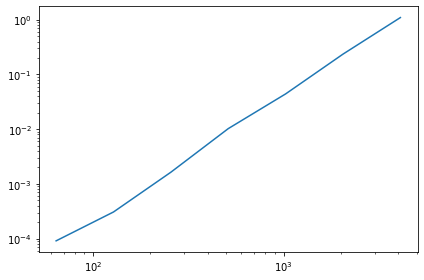

In [8]:
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

Предполагаемый slope близок к 2, а не к 3, как и ожидалось. Производительность np.linalg.solve примерно квадратична в этом диапазоне размеров массива.

Ниже результаты для analyze2:

In [9]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

64
53.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
315 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
1.64 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
512
5.44 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
24.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
86 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
306 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.0551554771800418

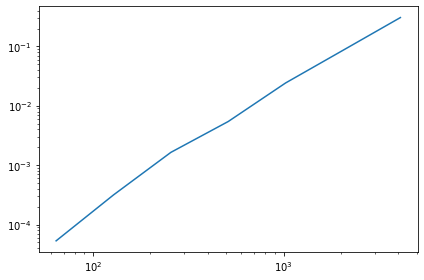

In [10]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

Результаты для analyze2 соответствуют прямой линии с slope, близким к 2, как и ожидалось.
Ниже представлены результаты для scipy.fftpack.dct.

In [11]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

64
7.68 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
128
7.62 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
9.15 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
9.75 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
12.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
2048
19.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
4096
37.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


0.36069806270084775

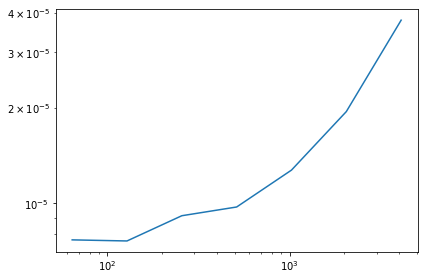

In [12]:
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

Эта реализация dct выполняется еще быстрее. Линия изогнута, это означает, что либо мы еще не видели асимптотического поведения, либо асимптотическое поведение не является простым показателем $n$.

На рисунке ниже показаны все три кривые.

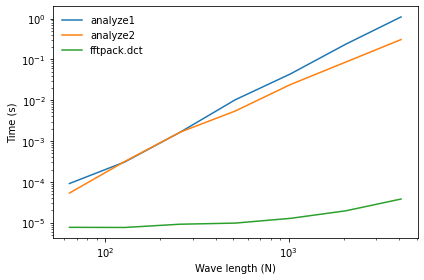

In [13]:
plt.plot(ns, bests, label='analyze1')
plt.plot(ns, bests2, label='analyze2')
plt.plot(ns, bests3, label='fftpack.dct')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', **loglog)

Упражнение 6.2
Одним из основных применений ДКП является сжатие как звука, так и изображений. В своей простейшей форме сжатие на основе ДКП работает следующим образом:
1) Разбивает длинный сигнал на сегменты.
2) Вычисляет ДКП каждого сегмента.
3) Определяет частотные компоненты с такой амплитудой, что их не слышно, и удаляет их, сохраняя только те частоты и амплитуды, которые остались.
4) При воспроизведении сигнала загружает частоты и амплитуды каждого сегмента и применяет обратное ДКП.

Реализуем версию этого алгоритма и применим его к записи музыки или речи. Сколько компонентов можно устранить, прежде чем разница станет заметной?

In [14]:
from thinkdsp import read_wave

wave = read_wave('624644__sonically_sound__medievalrpg-music.wav')
wave.make_audio()

Выделим короткий сегмент.

In [15]:
segment = wave.segment(start=1, duration=1)
segment.normalize()
segment.make_audio()

ДКП сегмента ниже.

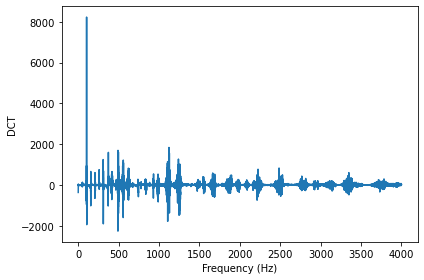

In [16]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Здесь есть немало гармоник со значительной амплитудой.
Функция ниже принимает значение ДКП и устанавливает элементы ниже порогового значения равными 0.

In [17]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1

    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

Если мы применим это к сегменту, мы сможем исключить около 80% элементов.

38627	48000	80.47291666666666


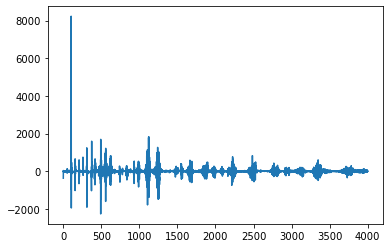

In [18]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

In [19]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Звук остался тем же (на мой взгляд).
Попробуем удалить больше компонент, чтобы разница стала заметной.

43472	48000	90.56666666666666


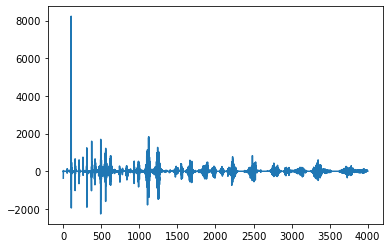

In [27]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=30)
seg_dct.plot(high=4000)

In [28]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Как мы слышим, при thresh = 30, уже заметна разница с оригиналом.

Чтобы сжать более длинный сегмент, мы можем сделать спектрограмму ДКП. Следующая функция похожа на wave.make_spectrogram, за исключением того, что она использует ДКП.

In [29]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Составим спектрограмму ДКП и применим сжатие к каждому сегменту.

In [30]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

775	1024	75.68359375
780	1024	76.171875
790	1024	77.1484375
780	1024	76.171875
772	1024	75.390625
773	1024	75.48828125
771	1024	75.29296875
781	1024	76.26953125
787	1024	76.85546875
792	1024	77.34375
774	1024	75.5859375
764	1024	74.609375
784	1024	76.5625
776	1024	75.78125
791	1024	77.24609375
793	1024	77.44140625
802	1024	78.3203125
758	1024	74.0234375
802	1024	78.3203125
781	1024	76.26953125
773	1024	75.48828125
747	1024	72.94921875
736	1024	71.875
770	1024	75.1953125
770	1024	75.1953125
757	1024	73.92578125
765	1024	74.70703125
777	1024	75.87890625
765	1024	74.70703125
766	1024	74.8046875
769	1024	75.09765625
776	1024	75.78125
757	1024	73.92578125
775	1024	75.68359375
767	1024	74.90234375
754	1024	73.6328125
770	1024	75.1953125
764	1024	74.609375
753	1024	73.53515625
754	1024	73.6328125
742	1024	72.4609375
750	1024	73.2421875
762	1024	74.4140625
760	1024	74.21875
769	1024	75.09765625
760	1024	74.21875
756	1024	73.828125
757	1024	73.92578125
763	1024	74.51171875
759	1024	74.12109375


В большинстве сегментов компрессия составляет 70-85%.
Чтобы услышать, как это звучит, мы можем преобразовать спектрограмму обратно в волну и воспроизвести ее.

In [31]:
wave2 = spectro.make_wave()
wave2.make_audio()

Сравним с оригиналом. Есть небольшая разница.

In [32]:
wave.make_audio()

Упражнение 6.3
Разберем примеры в phase.ipynb, в которых исследуется влияние фазы на восприятие звука.

Для звуков, которые имеют простую гармоническую структуру, мы не слышим изменений в фазовой структуре при условии, что гармоническая структура неизменна.

Возможным исключением являются звуки с низкой амплитудой на основной частоте. В этом случае мы могли бы использовать что-то похожее на автокорреляцию для восприятия высоты тона, и есть намеки на то, что этот анализ может быть более чувствительным к фазовой структуре.